<a href="https://colab.research.google.com/github/shintafiaa/Tel-U-ML-Course/blob/main/WEEK%209%20Multi%20Layer%20Perceptron%20and%20NN/3.1._Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In chapter 3 of d2l.ai will cover:
* the entire training process, 
* including defining simple neural network architectures,
* handling data,
* specifying a loss function, 
* training the model.  

#3.1. LINEAR REGRESSION

Regression refers to a set of methods for modeling the relationship between one or more independent variables and a dependent variable. In the natural sciences and social sciences, the purpose of regression is most often to characterize the relationship between the inputs and outputs. Machine learning, on the other hand, is most often concerned with **prediction.**

##3.1.1. Basic Elements of Linear Regression
Suppose that we wish to estimate the prices of houses (in dollars) based on their area (in square feet) and age (in years). 
###3.1.1.1. Linear Model

The linearity assumption just says that the target (price) can be expressed as a weighted sum of the features (area and age):
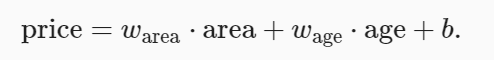

Given a dataset, our goal is to choose the weights  w  and the bias  b  such that on average, the predictions made according to our model best fit the true prices observed in the data.

###3.1.1.2. Loss Function
The loss function quantifies the distance between the real and predicted value of the target. The loss will usually be a non-negative number where smaller values are better and perfect predictions incur a loss of 0.

###3.1.1.3. Analytic Solution
There is just one critical point on the loss surface and it corresponds to the minimum of the loss over the entire domain. Taking the derivative of the loss with respect to  w  and setting it equal to zero yields the analytic (closed-form) solution:
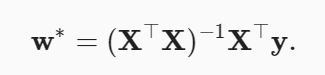

###3.1.1.4. Minibatch Stochastic Gradient Descent
The key technique for optimizing nearly any deep learning model, consists of iteratively reducing the error by updating the parameters in the direction that incrementally lowers the loss function. This algorithm is called gradient descent.

###3.1.1.5. Making Predictions with the Learned Model
Now estimate the price of a new house (not contained in the training data).

##3.1.2. Vectorization for Speed
When training our models, we typically want to process whole minibatches of examples simultaneously. Doing this efficiently requires that we vectorize the calculations and leverage fast linear algebra libraries rather than writing costly for-loops in Python.

In [21]:
#installation
!pip install d2l==0.17.2

  Using cached matplotlib-3.3.3-cp37-cp37m-manylinux1_x86_64.whl (11.6 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.0.2
    Uninstalling matplotlib-3.0.2:
      Successfully uninstalled matplotlib-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [22]:
#import library
import math
import time
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

To illustrate why this matters so much, we can consider two methods for adding vectors. To start we instantiate two 10000-dimensional vectors containing all ones. In one method we will loop over the vectors with a Python for-loop. In the other method we will rely on a single call to +.

In [23]:
n = 10000
a = tf.ones(n)
b = tf.ones(n)

Since we will benchmark the running time frequently in this book, let us define a timer.

In [24]:
class Timer:  
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

Now we can benchmark the workloads. First, we add them, one coordinate at a time, using a for-loop.

In [25]:
c = tf.Variable(tf.zeros(n))
timer = Timer()
for i in range(n):
    c[i].assign(a[i] + b[i])
f'{timer.stop():.5f} sec'

'7.35021 sec'

Alternatively, we rely on the reloaded + operator to compute the elementwise sum.

In [26]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00025 sec'

You probably noticed that the second method is dramatically faster than the first. Vectorizing code often yields order-of-magnitude speedups. Moreover, we push more of the mathematics to the library and need not write as many calculations ourselves, reducing the potential for errors.

##3.1.3. The Normal Distribution and Squared Loss

While you can already get your hands dirty using only the information above, in the following we can more formally motivate the squared loss objective via assumptions about the distribution of noise.

the probability density of a normal distribution with mean  μ  and variance  σ^2  (standard deviation  σ ) is given as:
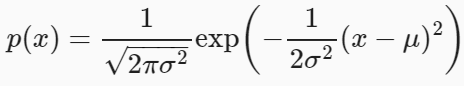

In [27]:
#define a Python function to compute the normal distribution
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

Visualize the normal distributions

In [28]:
pip install matplotlib==3.0.2

  Using cached matplotlib-3.0.2-cp37-cp37m-manylinux1_x86_64.whl (12.9 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotlib-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
d2l 0.17.2 requires matplotlib==3.3.3, but you have matplotlib 3.0.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


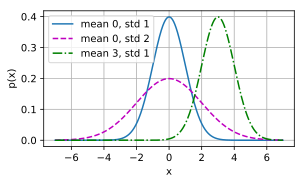

In [29]:
# Use numpy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

As we can see, changing the mean corresponds to a shift along the  x -axis, and increasing the variance spreads the distribution out, lowering its peak.

##3.14. From Linear Regression to Deep Networks

###3.1.4.1. Neural Network Diagram
![Linear regression is a single-layer neural network.](http://d2l.ai/_images/singleneuron.svg)

For the neural network shown above,
the inputs are $x_1, \ldots, x_d$,
so the *number of inputs* (or *feature dimensionality*) in the input layer is $d$.

The output of the network above is $o_1$,
so the *number of outputs* in the output layer is 1.

Focusing on where computation takes place,
conventionally we do not consider the input layer when counting layers.
That is to say,
the *number of layers* for the neural network in the case-above is 1.

We can think of linear regression models as neural networks
consisting of just a single artificial neuron,
or as single-layer neural networks.

Since for linear regression, every input is connected
to every output (in this case there is only one output),
we can regard this transformation as a fully-connected layer or *dense layer*.


###3.1.4.2. Biology
![The real neuron.](http://d2l.ai/_images/neuron.svg)

Information $x_i$ arriving from other neurons
(or environmental sensors such as the retina)
is received in the dendrites.
In particular, that information is weighted by *synaptic weights* $w_i$
determining the effect of the inputs
(e.g., activation or inhibition via the product $x_i w_i$).
The weighted inputs arriving from multiple sources
are aggregated in the nucleus as a weighted sum $y = \sum_i x_i w_i + b$,
and this information is then sent for further processing in the axon $y$,
typically after some nonlinear processing via $\sigma(y)$.
From there it either reaches its destination (e.g., a muscle)
or is fed into another neuron via its dendrites.
